# Overview

The main purpose of this repository is to cover the below items, without use of any Image processing libraries:
- Transforming RGB color images back and forth from the YIQ color space.
- Performing intensity transformations: histogram equalization.
- Performing optimal quantization

# Reading an image into a given representation
a function that reads a given image file and converts it into a given representation. 

Nocite that the output image is represented by a matrix of class float with intensities (ei-
their grayscale or RGB channel intensities) normalized to the range [0; 1].

In [1]:
from typing import List
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

LOAD_GRAY_SCALE = 1
LOAD_RGB = 2
YIQ_MAT = np.array([[0.299, 0.587, 0.114],
                    [0.59590059, -0.27455667, -0.32134392],
                    [0.21153661, -0.52273617, 0.31119955]])
IMG_INT_MAX_VAL = 255


In [2]:
def imReadAndConvert(filename: str, representation: int) -> np.ndarray:
    """
    Reads an image, and returns the image converted as requested
    :param filename: The path to the image
    :param representation: GRAY_SCALE or RGB
    :return: The image object
    """
    img = cv2.imread(filename, -1)
    if representation is LOAD_RGB:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize to range [0,1]
    img = img.astype(float) / IMG_INT_MAX_VAL

    if representation is LOAD_GRAY_SCALE \
            and len(img.shape) > 2:
        b, g, r = np.split(img, 3, axis=2)
        img = 0.3 * r + 0.59 * g + 0.11 * b
        img = img.squeeze()
    elif representation is LOAD_RGB \
            and len(img.shape) < 3:
        img = np.stack((img, img, img), axis=2)

    return img

# Displaying an image
A function that utilizes imReadAndConvert to display a given image file in a given representation.

The function  opens a new figure window and display the loaded image in the converted representation. The fuction use the plt.imshow function to display the image and due to the fact that matplotlib assumes
RGB, the functions adresses that properlly.

In [3]:
def imDisplay(image: np.ndarray, representation: int):
    """
    Reads an image as RGB or GRAY_SCALE and displays it
    :param filename: The path to the image
    :param representation: GRAY_SCALE or RGB
    :return: None
    """
    plt.gray()
    plt.imshow(img)
    plt.show()

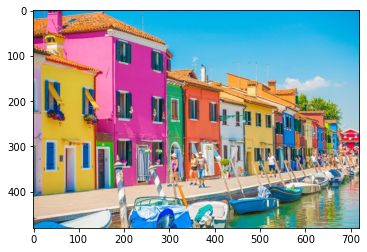

In [4]:
img = imReadAndConvert('colorful.jpg',2)
imDisplay(img, 2)

# Transforming an RGB image to YIQ color space

Two functions that transform an RGB image into the YIQ color space (mentioned in the lecture)
and vice versa. Given the red (R), green (G), and blue (B) pixel components of an RGB color image,
the corresponding luminance (Y), and the chromaticity components (I and Q) in the YIQ color space are
linearly related as follows:




$\begin{bmatrix}Y \\ I \\ Q \end{bmatrix} =\begin{bmatrix}
0.299 & 0.587 & 0.114\\
0.596 & -0.275 & -0.321\\
0.212 & -0.523 & 0.311
\end{bmatrix}
\begin{bmatrix}R \\ G \\ B
\end{bmatrix}$


where both imRGB and imYIQ are height x width x 3 double matrices. In the RGB case the red channel is
encoded in imRGB[:,:,0], the green in imRGB[:,:,1], and the blue in imRGB[:,:,2]. Similarly for YIQ,
imYIQ[:,:,0] encodes the luminance channel Y, imYIQ[:,:,1] encodes I, and imYIQ[:,:,2] encodes
Q.

In [5]:
def transformRGB2YIQ(imgRGB: np.ndarray) -> np.ndarray:
    """
    Converts an RGB image to YIQ color space
    :param imgRGB: An Image in RGB
    :return: A YIQ in image color space
    """
    return np.dot(imgRGB,YIQ_MAT.T)


def transformYIQ2RGB(imgYIQ: np.ndarray) -> np.ndarray:
    """
    Converts an YIQ image to RGB color space
    :param imgYIQ: An Image in YIQ
    :return: A RGB in image color space
    """
    rgb = imgYIQ.dot(np.linalg.inv(YIQ_MAT).T)

    # Values clipping
    rgb[rgb > 1] = 1
    rgb[rgb < 0] = 0
    return rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


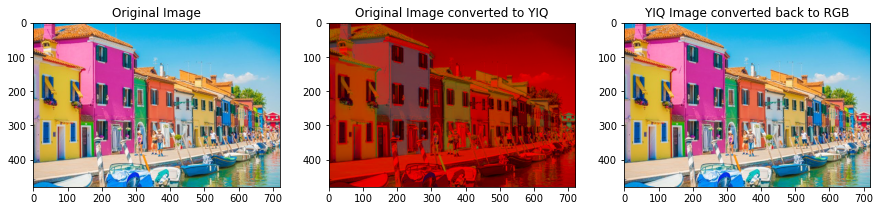

In [6]:
f, ax = plt.subplots(1, 3,figsize=(15,15))
ax[0].imshow(img)
ax[0].set_title('Original Image')

yiq_img = transformRGB2YIQ(img)
ax[1].imshow(yiq_img)
ax[1].set_title('Original Image converted to YIQ')

ax[2].imshow(transformYIQ2RGB(yiq_img))
ax[2].set_title('YIQ Image converted back to RGB')

plt.show()

# Histogram equalization


A function that performs histogram equalization of a given grayscale or RGB image in order to improve its contrust.
The function also display the input and the equalized output image.
The function have the following interface:

histogramEqualize(imOrig:np.ndarray)->(np.ndarray,np.ndarray,np.ndarray):

" " "

Equalizes the histogram of an image

:param imgOrig: Original image

:return: (imgEq,histOrg,histEQ)

" " "

where:
- imOrig - is the input grayscale or RGB image to be equalized having values in the range [0; 1].
- imEq - the new image with the equalized histogram
- histOrg - the histogram of the original image
- histEQ - the histogram of the imgEq
If an RGB image is given the following equalization procedure should only operate on the Y channel
of the corresponding YIQ image and then convert back from YIQ to RGB.

In [7]:
def calHist(img: np.ndarray, bins=256, hist_range: tuple = (0, 256)) -> np.ndarray:
    """
    Calculate the image histogram
    :param img: Input image
    :param bins: Number of bins to group the values
    :param hist_range: The range of values
    :return: An np.array of size (bins)
    """
    img_flat = img.ravel()
    min_val = hist_range[0]
    max_val = hist_range[1]
    hist = np.zeros(bins)

    for pix in img_flat:
        quan_val = int(bins * (pix - min_val) / (max_val - min_val))
        hist[quan_val] += 1

    return hist


def calCumSum(arr: np.array) -> np.ndarray:
    """
    Calculate the Cumulitive Sum of an array
    :param arr: Input array
    :return: A CumSum array of size (len(arr))
    """
    cum_sum = np.zeros_like(arr)
    cum_sum[0] = arr[0]
    arr_len = len(arr)
    for idx in range(1, arr_len):
        cum_sum[idx] = arr[idx] + cum_sum[idx - 1]

    return cum_sum


def histogramEqualize(imgOrig: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Equalizes the histogram of an image
        :param imgOrig: Original Histogram
        :ret
    """
    gray = imgOrig
    yiq = None
    if len(imgOrig.shape) > 2:
        yiq = transformRGB2YIQ(imgOrig)
        gray = yiq[:, :, 0]

    gray = (gray * IMG_INT_MAX_VAL).astype(np.uint8)

    hist_org = calHist(gray)
    cumsum = calCumSum(hist_org)
    cumsum_n = cumsum / cumsum[-1]

    LUT = (IMG_INT_MAX_VAL * cumsum_n).astype(int)

    eq_img = np.zeros_like(gray, dtype=float)
    for old_color, new_color in enumerate(LUT):
        eq_img[gray == old_color] = new_color

    hist_eq = calHist(eq_img)
    eq_img /= IMG_INT_MAX_VAL

    if yiq is not None:
        yiq[:, :, 0] = eq_img
        eq_img = transformYIQ2RGB(yiq)

    # Display Results:
    s, axe = plt.subplots(1, 2,figsize=(15,15))  
    
    axe[0].plot(hist_org)
    axe[0].set_box_aspect(1)
    axe[0].set_title('Original Image Histogram')
    axe[1].plot(range(256),hist_eq)
    axe[1].set_box_aspect(1)
    axe[1].set_title('Equalized Image Histogram')
    
    
    f, ax = plt.subplots(1, 3,figsize=(15,15))      
    cumsum = calCumSum(hist_org)
    cumsum_eq = calCumSum(hist_eq)

    ax[0].plot(range(256), cumsum, 'r.',label='Original Image')
    ax[0].plot(range(256), cumsum_eq, 'g',label='Equalized Image')
    ax[0].set_title('Image Cumulative Sum')
    ax[0].legend(loc="upper left")
    ax[0].set_box_aspect(1)


    ax[1].imshow(img)
    ax[1].set_title('Original Image')

    ax[2].imshow(eq_img)
    ax[2].set_title('Equalized Image')

    plt.show()

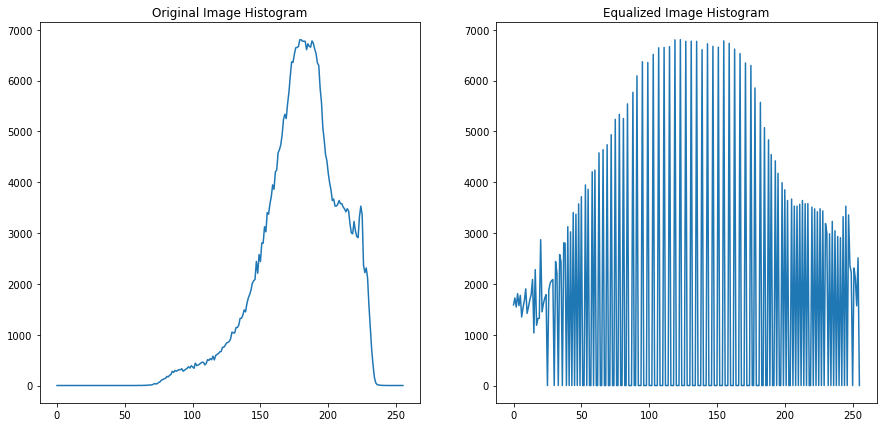

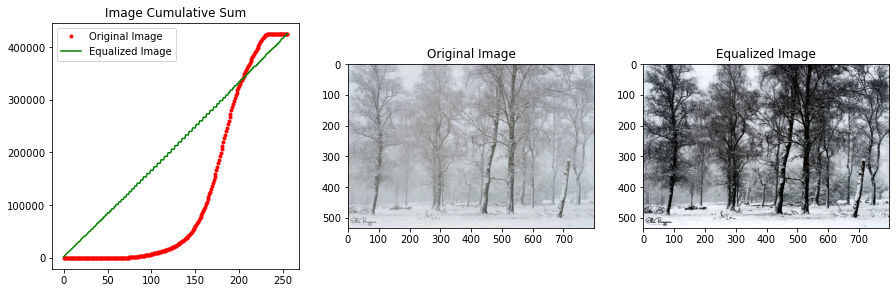

In [8]:
img = imReadAndConvert('bad_contrust1.jpg',2)
histogramEqualize(img)

# image quantization

A function that performs quantization of a given grayscale or RGB image. The function return:
- A list of the quantized image in each iteration
- A list of the MSE error in each iteration


If an RGB image is given, the following quantization procedure only operate on the Y channel
of the corresponding YIQ image and then convert back from YIQ to RGB.

Each iteration in the quantization process contains two steps:

- Finding z - the borders which divide the histograms into segments. z is a vector containing nQuant+1
elements. The first and last elements are 0 and 255 respectively.
- Finding q - the values that each of the segments' intensities will map to. q is also a vector, however,
containing nQuant elements.

More comments:
- The function perform the two steps above nIter times.
- The function find z and q by minimizing the total intensities error. The close form expressions for z
and q can be found as follows:

$ min \sum \limits _{i=0} ^{k} \int \limits _{z_i} ^{\infty} {(q_i-z)}^{2} dz $  

- The quantization procedure has an initial segment division of [0..255] to segments, z. If a division
will have a grey level segment with no pixels, the procedure will crash. In order to overcome this
problem, the initial division set such that each segment will contain approximately
the same number of pixels.
- The output error is a vector with nIter elements (or less in case of converges). Each element is
the total intensities error in a current iteration. The exact error calculation is as follows:

$ \sum \limits _{i=1} ^{n} w_i {(x_i-\hat{x})}^{2}  $ 

- Notice, the function plot the error as a function of the iteration number. A sanity check makes sure that the error graph is monotonically descending.

Notice : after quantization (with the YIQ transform), the RGB image will have more than the
desired colors. To get better results the function uses the KMeans algorithm.

In [9]:
def getWeightedMean(vals: np.ndarray, weights: np.ndarray) -> int:
    """
    Calculats the weighted mean of
    :param vals:
    :param weights:
    :return:
    """
    val = (vals * weights).sum() / (weights.sum() + np.finfo('float').eps)
    return val.astype(int)


def recolor(img: np.ndarray, borders: np.ndarray, weighted_mean: np.ndarray) -> np.ndarray:
    """
    Recolors the image according to the borders and the cells's means
    :param img: The original image
    :param borders: The borders
    :param weighted_mean: The cells's means
    :return: The recolored image
    """
    img_quant = np.zeros_like(img)
    for q in range(len(borders) - 1):
        left_b = borders[q]
        right_b = borders[q + 1]
        min_val_matrix = img >= left_b
        max_val_matrix = img < right_b
        img_quant[max_val_matrix * min_val_matrix] = weighted_mean[q]
    return img_quant


def dispBorders(hist: np.ndarray, borders: np.ndarray, qs: np.ndarray, err) -> None:
    """
    Displays the histogram with the borders and the cells's means
    :param hist: The histograms
    :param borders: The borders array
    :param qs: The cells's means array
    :param err: The error
    :return: None
    """
    plt.ion()
    max_val = hist.max()
    plt.bar(range(len(hist)), hist, color='b')
    plt.plot(qs, hist[qs.astype(int)], 'r*')
    for b in borders:
        plt.axvline(x=b, ymin=0, ymax=max_val, c='y')
    plt.title("Error: {}".format(err))



def quantizeImage(imOrig: np.ndarray, nQuant: int, nIter: int, verbos=False) -> (List[np.ndarray], List[float]):
    """
        Quantized an image in to **nQuant** colors
        :param imOrig: The original image (RGB or Gray scale)
        :param nQuant: Number of colors to quantize the image to
        :param nIter: Number of optimization loops
        :return: (List[qImage_i],List[error_i])
    """
    gray = imOrig
    if len(imOrig.shape) > 2:
        yiq = transformRGB2YIQ(imOrig)
        gray = yiq[:, :, 0]
        comp_img = imOrig
    else:
        comp_img = (gray * IMG_INT_MAX_VAL).astype(int)
    gray = (gray * IMG_INT_MAX_VAL).astype(int)

    hist = calHist(gray)
    cumsum = calCumSum(hist)
    cumsum /= cumsum[-1]

    # Initiating the borders
    borders = np.arange(gray.min(), gray.max(), gray.max() / nQuant, dtype=np.float64)
    max_val = gray.max() + 1
    borders = np.hstack([borders, max_val])
    weighted_mean = np.array([borders[x:x + 2].mean() for x in range(len(borders[:-1]))])

    # Calculate histogram
    error_trk = []
    img_quant_trk = []
    # dispBorders(hist, borders, weighted_mean, 100)
    for it in range(nIter):
        # Find quants means
        for q in range(nQuant):
            left_b = int(np.floor(borders[q]))
            right_b = int(np.ceil(borders[q + 1]))
            q_vals = hist[left_b:right_b]
            weighted_mean[q] = getWeightedMean(np.arange(left_b, right_b), q_vals)

        # Make shift borders
        borders = np.zeros_like(borders)
        borders[-1] = max_val
        for q in range(1, nQuant):
            borders[q] = weighted_mean[q - 1:q + 1].mean()

        # Recolor the image
        tmp = recolor(gray, borders, weighted_mean)
        if len(imOrig.shape) > 2:
            tmp_yiq = yiq.copy()
            tmp_yiq[:, :, 0] = tmp / IMG_INT_MAX_VAL
            tmp = transformYIQ2RGB(tmp_yiq)
            tmp[tmp > 1] = 1
            tmp[tmp < 0] = 0
        img_quant_trk.append(tmp)
        error_trk.append(np.power(comp_img - tmp, 2).mean())

        if verbos:
            print(len(set(borders)))
            print('#{} Error: {}'.format(it, error_trk[-1]))
            dispBorders(hist, borders, weighted_mean, error_trk[-1])

    # display results:
    dispBorders(hist, borders, weighted_mean, error_trk[-1])
    
    f, ax = plt.subplots(1, 3,figsize=(15,15))
    
    ax[0].plot(error_trk)
    ax[0].set_title('Error Per Iteration')
    ax[0].set_box_aspect(1)
    
    ax[1].imshow(img)
    ax[1].set_title('Original Image')

    ax[2].imshow(img_quant_trk[-1])
    ax[2].set_title('Quantized Image')

    plt.show()

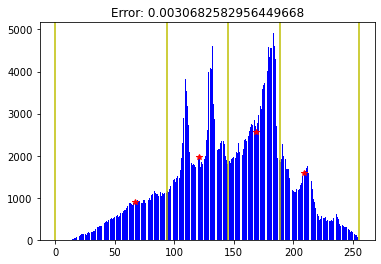

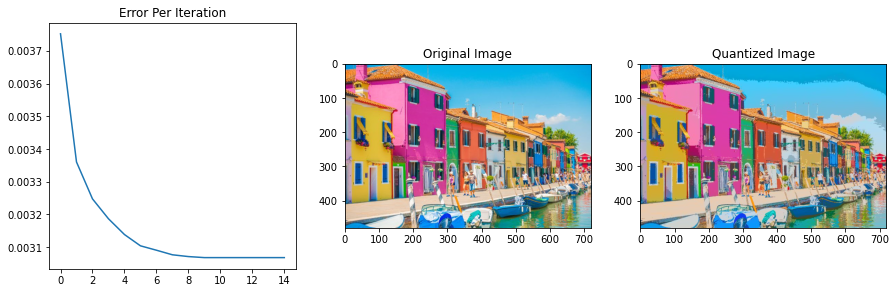

In [10]:
img = imReadAndConvert('colorful.jpg',2)
quantizeImage(img, 4, 15, False)

# image quantization using Kmeans

Notice that after quantization (with the YIQ transform), RGB returned more than the desired colors. 
To get better results the function we use the KMeans algorithm:

In [11]:
def kmeans(pnts: np.ndarray, k: int, iter_num: int = 7) -> (np.ndarray, List[np.ndarray]):
    """
    Calculates K-Means
    :param pnts: The data, a [nXm] array, **n** samples of **m** dimentions
    :param k: Numbers of means
    :param iter_num: Number of K-Means iterations
    :return: [k,m] centers,
             List of the history of assignments, each assignment is a [n,1]
             array with assignment of each data point to center,
    """
    if len(pnts.shape) > 1:
        n, m = pnts.shape
    else:
        n = pnts.shape[0]
        m = 1
    pnts = pnts.reshape((n, m))
    assign_array = np.random.randint(0, k, n).astype(np.uint8)
    centers = np.zeros((k, m))

    assign_history = []
    for it in range(iter_num):
        # Find centers
        for i, _ in enumerate(centers):
            if sum(assign_array == i) < 1:
                continue
            centers[i] = pnts[assign_array == i, :].mean(axis=0)

        # Assign pixels to centers
        for i, p in enumerate(pnts):
            center_dist = np.power(centers - p, 2).sum(axis=1)
            assign_array[i] = np.argmin(center_dist)
        assign_history.append(assign_array.copy())

    return centers, assign_history


def quantizeImageKmeans(imOrig: np.ndarray, nQuant: int, nIter: int) -> (List[np.ndarray], List[float]):
    """
    Quantized an image in to **nQuant** colors
    :param imOrig: The original image (RGB or Gray scale)
    :param nQuant: Number of colors to quantize the image to
    :param nIter: Number of iterations for the KMeans
    :return: (List[qImage_i],List[error_i])
    """

    gray = imOrig / imOrig.max()
    if len(gray.shape) > 2:
        data = gray.reshape((-1, 3))
        height, width, _ = gray.shape
    else:
        data = gray.reshape(-1)

    cs, assignment = kmeans(data, nQuant, nIter)

    assign_list = []
    error_list = []
    for assign_i in assignment:
        qunt_img = np.zeros(data.shape)
        for i, c in enumerate(cs):
            qunt_img[assign_i == i] = c
        qunt_img = qunt_img.reshape(gray.shape)

        error = np.square((qunt_img - gray) * IMG_INT_MAX_VAL).mean()
        assign_list.append(qunt_img)
        error_list.append(error)

#     return assign_list, error_list

    # display results:
    f, ax = plt.subplots(1, 2,figsize=(15,15))
    
    
    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    ax[1].imshow(assign_list[-1])
    ax[1].set_title('Quantized Image')

    plt.show()

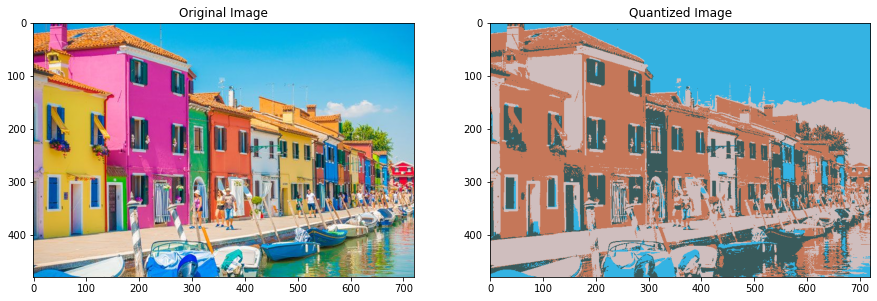

In [12]:
quantizeImageKmeans(img, nQuant=4, nIter=5)